# Decision Tree Classifier

In this notebook, we explore and tune the parameters for the DecisionTreeClassifier to predict if PA forms will be approved. We will be using Drug, BIN, Reject Code, and flags for Tried & Failed, Contraindication, and Correct Diagnosis for prediction. First, we import the needed packages.

In [1]:
##Import packages
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
## Import packages
## tree will be used to plot the decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

## Import splits and metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

Now, we create our train test split, making sure to stratify on PA approval. We choose our test set to be 20% of the available data, and use the same random seed in all other model notebooks. We will use the test set after choosing our final model (and not in this notebook).

In [3]:
#import cleaned CSV (no date information)
cmm_pa_clf_read = pd.read_csv("../Data/cmm_pa_clf.csv",index_col = 0)

#drop pa_approved for the predictors, only use it for target.
cmm_pa_clf_data = cmm_pa_clf_read.drop(columns = 'pa_approved').copy()
cmm_pa_clf_target = cmm_pa_clf_read['pa_approved'].copy()
X_train,X_test,y_train,y_test= train_test_split(cmm_pa_clf_data, cmm_pa_clf_target, test_size = 0.2, 
                                             random_state = 10475, shuffle = True,
                                            stratify = cmm_pa_clf_target)

## Baseline Model

Our baseline model will be predicting all claims will have PA approved, as the majority of claims are approved.

In [4]:
if y_train.value_counts(normalize=True)[1]>.5:
    print(np.round(y_train.value_counts(normalize=True)[1]*100,3),"percent of the training set has PA approved, so",
          "our baseline model will predict all PA forms are approved.")
else:
    print(np.round(y_train.value_counts(normalize=True)[1]*100,3),"percent of the training set has PA approved, so",
          "our baseline model will predict all PA forms are declined.")

73.445 percent of the training set has PA approved, so our baseline model will predict all PA forms are approved.


## Cross-Validation
We perform 5-fold cross validation to explore the accuracy rate and roc_auc as we change max depth and gini/entropy.

### Max-depth
Here, we look at varying max_depth of the tree from 3 to 14 levels. We will compare the average (over the validation sets) accuracy and ROC-AUC scores for each depth, along with our baseline model.

In [5]:
#kfold cross validation, and max_depth range
kfold = StratifiedKFold(5, shuffle=True, random_state=10475)
depth = range(3,15)

#matrices to hold accuracy and ROC-AUC scores for validation sets and train subsets
cv_accs = np.zeros((5, len(depth)+1))
cv_accs_train = np.zeros((5, len(depth)+1))
cv_aucs = np.zeros((5, len(depth)+1))
cv_aucs_train = np.zeros((5, len(depth)+1))


i = 0
#loop through the cross-validation subsets
for train_index, test_index in  kfold.split(X_train, y_train):
    X_train_train = X_train.iloc[train_index]
    X_holdout = X_train.iloc[test_index]
    y_train_train  =  y_train.iloc[train_index]
    y_holdout = y_train.iloc[test_index]
    
    #baseline performance on the train and validation sets
    cv_accs_train[i,0] = accuracy_score(y_train_train, np.ones(len(y_train_train)))
    cv_aucs_train[i,0] = roc_auc_score(y_train_train, np.ones(len(y_train_train)))

    cv_accs[i,0] = accuracy_score(y_holdout, np.ones(len(y_holdout)))
    cv_aucs[i,0] = roc_auc_score(y_holdout, np.ones(len(y_holdout)))    
    
    j = 1
    #loop through the trees with varying depth
    for d in depth:
        dtree=DecisionTreeClassifier(max_depth=d,random_state=10475)
        dtree.fit(X_train_train, y_train_train)
        
        #save scores for train subset and validation set
        cv_accs_train[i,j] = accuracy_score(y_train_train, dtree.predict(X_train_train))
        cv_aucs_train[i,j] = roc_auc_score(y_train_train, dtree.predict_proba(X_train_train)[:,1])
        
        cv_accs[i,j] = accuracy_score(y_holdout, dtree.predict(X_holdout))
        cv_aucs[i,j] = roc_auc_score(y_holdout, dtree.predict_proba(X_holdout)[:,1])
        j = j + 1
    i = i + 1

In [6]:
print("The accuracy scores:")
print("For training subsets:",np.mean(cv_accs_train,axis=0))
print("For the validation subsets:",np.mean(cv_accs,axis=0))
print("The ROC-AUC scores:")
print("For training subsets:",np.mean(cv_aucs_train,axis=0))
print("For the validation subsets:",np.mean(cv_aucs,axis=0))

The accuracy scores:
For training subsets: [0.73445229 0.78744491 0.80917349 0.81310651 0.81421497 0.81434369
 0.81434369 0.81434369 0.81434369 0.81434369 0.81434369 0.81434369
 0.81434369]
For the validation subsets: [0.73445229 0.78744491 0.80917349 0.81295305 0.81406152 0.81372426
 0.81372426 0.81372426 0.81372426 0.81372426 0.81372426 0.81372426
 0.81372426]
The ROC-AUC scores:
For training subsets: [0.5        0.83694475 0.864191   0.87564946 0.8777366  0.8782139
 0.87823433 0.87823433 0.87823433 0.87823433 0.87823433 0.87823433
 0.87823433]
For the validation subsets: [0.5        0.83694374 0.86418024 0.87560508 0.8776088  0.87808599
 0.87808968 0.87808968 0.87808968 0.87808968 0.87808968 0.87808968
 0.87808968]


In [7]:
if np.argmax(np.mean(cv_accs,axis=0)==0):
    print("None of these models beat our baseline model on accuracy.")
else:
    #if we change the depth range, this will automatically change, depth[0] is the minimum depth, the -1 compensates for the baseline at position 0
    print("The model with the best accuracy had max_depth",depth[0]+np.argmax(np.mean(cv_accs,axis=0))-1)
if np.argmax(np.mean(cv_accs,axis=0)==0):
    print("None of these models beat our baseline model on ROC AUC score.")
else:
    #if we change the depth range, this will automatically change, depth[0] is the minimum depth, the -1 compensates for the baseline at position 0
    print("The model with the best ROC AUC score had max_depth",depth[0]+np.argmax(np.mean(cv_aucs,axis=0))-1)

The model with the best accuracy had max_depth 6
The model with the best ROC AUC score had max_depth 8


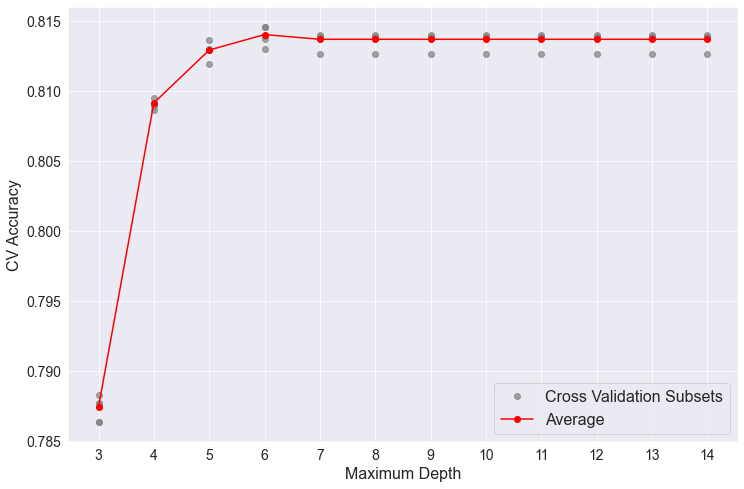

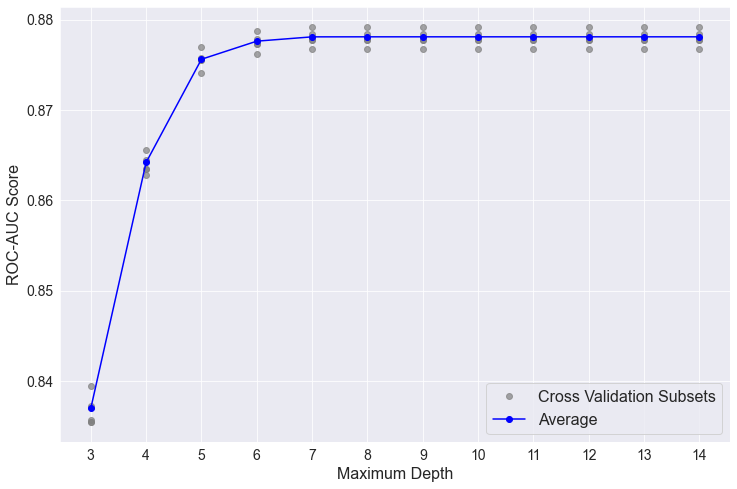

In [8]:
## this plots the average accuracy and accuracy for the CV subsets as a function of the maximum depth
plt.figure(figsize=(12,8))

#plot CV accuracies (one outside loop for non-repeating legend)
plt.plot(depth,cv_accs[1,1:],'o',color='gray',alpha=.7,label='Cross Validation Subsets') 
for i in range(1,5):
    plt.plot(depth,cv_accs[i,1:],'o',color='gray',alpha=.7,label='_no_legend_')
    
#Plot average CV accuracy 
plt.plot(depth,np.mean(cv_accs[:,1:], axis=0),
         '-o',color='red',
         label="Average")

plt.legend(fontsize=16)

plt.xlabel("Maximum Depth", fontsize=16)
plt.ylabel("CV Accuracy", fontsize=16)

plt.xticks(depth, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## this plots the average ROC-AUC and ROC-AUC for the CV subsets as a function of the maximum depth
plt.figure(figsize=(12,8))

#plot CV ROC-AUC scores (one outside loop for non-repeating legend)
plt.plot(depth,cv_aucs[1,1:],'o',color='gray',alpha=.7,label='Cross Validation Subsets') 
for i in range(1,5):
    plt.plot(depth,cv_aucs[i,1:],'o',color='gray',alpha=.7,label='_no_legend_')
    
#Plot average CV accuracy 
plt.plot(depth,np.mean(cv_aucs[:,1:], axis=0),
         '-o',color='blue',
         label="Average")

plt.legend(fontsize=16)

plt.xlabel("Maximum Depth", fontsize=16)
plt.ylabel("ROC-AUC Score", fontsize=16)

plt.xticks(depth, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

### Max-depth
Here, we look at changing the split criterion, comparing gini and entropy for max_depth of the tree from 5 to 9 levels. We will compare the average (over the validation sets) accuracy and ROC-AUC scores for these 10 models, along with our baseline model.

In [9]:
#kfold cross validation, and max_depth range
kfold = StratifiedKFold(5, shuffle=True, random_state=10475)
depth = range(5,10)

#matrices to hold accuracy and ROC-AUC scores for validation sets and train subsets
cv_accs_gini = np.zeros((5, len(depth)+1))
cv_accs_train_gini = np.zeros((5, len(depth)+1))
cv_aucs_gini = np.zeros((5, len(depth)+1))
cv_aucs_train_gini = np.zeros((5, len(depth)+1))

cv_accs_ent = np.zeros((5, len(depth)+1))
cv_accs_train_ent = np.zeros((5, len(depth)+1))
cv_aucs_ent = np.zeros((5, len(depth)+1))
cv_aucs_train_ent = np.zeros((5, len(depth)+1))


i = 0
#loop through the cross-validation subsets
for train_index, test_index in  kfold.split(X_train, y_train):
    X_train_train = X_train.iloc[train_index]
    X_holdout = X_train.iloc[test_index]
    y_train_train  =  y_train.iloc[train_index]
    y_holdout = y_train.iloc[test_index]
    
    #baseline performance on the train and validation sets (stored in both sets of arrays)
    cv_accs_train_gini[i,0] = accuracy_score(y_train_train, np.ones(len(y_train_train)))
    cv_aucs_train_gini[i,0] = roc_auc_score(y_train_train, np.ones(len(y_train_train)))

    cv_accs_gini[i,0] = accuracy_score(y_holdout, np.ones(len(y_holdout)))
    cv_aucs_gini[i,0] = roc_auc_score(y_holdout, np.ones(len(y_holdout)))    
    
    cv_accs_train_ent[i,0] = accuracy_score(y_train_train, np.ones(len(y_train_train)))
    cv_aucs_train_ent[i,0] = roc_auc_score(y_train_train, np.ones(len(y_train_train)))

    cv_accs_ent[i,0] = accuracy_score(y_holdout, np.ones(len(y_holdout)))
    cv_aucs_ent[i,0] = roc_auc_score(y_holdout, np.ones(len(y_holdout)))  
    
    j = 1
    #loop through the trees with varying depth
    for d in depth:
        dtree_gini=DecisionTreeClassifier(criterion='gini',max_depth=d,random_state=10475)
        dtree_gini.fit(X_train_train, y_train_train)

        dtree_ent=DecisionTreeClassifier(criterion='entropy',max_depth=d,random_state=10475)
        dtree_ent.fit(X_train_train, y_train_train)
        
        #save scores for train subset and validation set
        cv_accs_train_gini[i,j] = accuracy_score(y_train_train, dtree_gini.predict(X_train_train))
        cv_aucs_train_gini[i,j] = roc_auc_score(y_train_train, dtree_gini.predict_proba(X_train_train)[:,1])
        
        cv_accs_gini[i,j] = accuracy_score(y_holdout, dtree_gini.predict(X_holdout))
        cv_aucs_gini[i,j] = roc_auc_score(y_holdout, dtree_gini.predict_proba(X_holdout)[:,1])
        
        cv_accs_train_ent[i,j] = accuracy_score(y_train_train, dtree_ent.predict(X_train_train))
        cv_aucs_train_ent[i,j] = roc_auc_score(y_train_train, dtree_ent.predict_proba(X_train_train)[:,1])
        
        cv_accs_ent[i,j] = accuracy_score(y_holdout, dtree_ent.predict(X_holdout))
        cv_aucs_ent[i,j] = roc_auc_score(y_holdout, dtree_ent.predict_proba(X_holdout)[:,1])
        j = j + 1
    i = i + 1

In [10]:
print("The gini accuracy scores:")
print("For training subsets:",np.mean(cv_accs_train_gini,axis=0))
print("For the validation subsets:",np.mean(cv_accs_gini,axis=0))
print("The entropy accuracy scores:")
print("For training subsets:",np.mean(cv_accs_train_ent,axis=0))
print("For the validation subsets:",np.mean(cv_accs_ent,axis=0))
print("The gini ROC-AUC scores:")
print("For training subsets:",np.mean(cv_aucs_train_gini,axis=0))
print("For the validation subsets:",np.mean(cv_aucs_gini,axis=0))
print("The entropy ROC-AUC scores:")
print("For training subsets:",np.mean(cv_aucs_train_ent,axis=0))
print("For the validation subsets:",np.mean(cv_aucs_ent,axis=0))

The gini accuracy scores:
For training subsets: [0.73445229 0.81310651 0.81421497 0.81434369 0.81434369 0.81434369]
For the validation subsets: [0.73445229 0.81295305 0.81406152 0.81372426 0.81372426 0.81372426]
The entropy accuracy scores:
For training subsets: [0.73445229 0.81310651 0.81421497 0.81434369 0.81434369 0.81434369]
For the validation subsets: [0.73445229 0.81295305 0.81406152 0.81372426 0.81372426 0.81372426]
The gini ROC-AUC scores:
For training subsets: [0.5        0.87564946 0.8777366  0.8782139  0.87823433 0.87823433]
For the validation subsets: [0.5        0.87560508 0.8776088  0.87808599 0.87808968 0.87808968]
The entropy ROC-AUC scores:
For training subsets: [0.5        0.87567919 0.87773647 0.8782139  0.87823433 0.87823433]
For the validation subsets: [0.5        0.87566045 0.87760949 0.87808599 0.87808968 0.87808968]


In [11]:
if np.argmax(np.mean(cv_accs_gini,axis=0)==0) and np.argmax(np.mean(cv_accs_ent,axis=0)==0):
    print("None of the models beat our baseline model on accuracy.")
else:
    #holder for best gini and entropy index
    g=np.argmax(np.mean(cv_accs_gini,axis=0))
    e=np.argmax(np.mean(cv_accs_ent,axis=0))
    if np.mean(cv_accs_gini,axis=0)[g]>=np.mean(cv_accs_ent,axis=0)[e]:
        print("The model with the best accuracy was gini with max_depth",depth[0]+np.argmax(np.mean(cv_accs_gini,axis=0))-1)
    else:
        print("The model with the best accuracy was entropy with max_depth",depth[0]+np.argmax(np.mean(cv_accs_ent,axis=0))-1)
if np.argmax(np.mean(cv_accs_gini,axis=0)==0) and np.argmax(np.mean(cv_accs_ent,axis=0)==0):
    print("None of these models beat our baseline model on ROC AUC score.")
else:
    #holder for best gini and entropy index
    g=np.argmax(np.mean(cv_aucs_gini,axis=0))
    e=np.argmax(np.mean(cv_aucs_ent,axis=0))
    if np.mean(cv_aucs_gini,axis=0)[g]>=np.mean(cv_aucs_ent,axis=0)[e]:
        print("The model with the best ROC-AUC was gini with max_depth",depth[0]+np.argmax(np.mean(cv_aucs_gini,axis=0))-1)
    else:
        print("The model with the best ROC-AUC was entropy with max_depth",depth[0]+np.argmax(np.mean(cv_aucs_ent,axis=0))-1)


The model with the best accuracy was gini with max_depth 6
The model with the best ROC-AUC was gini with max_depth 8


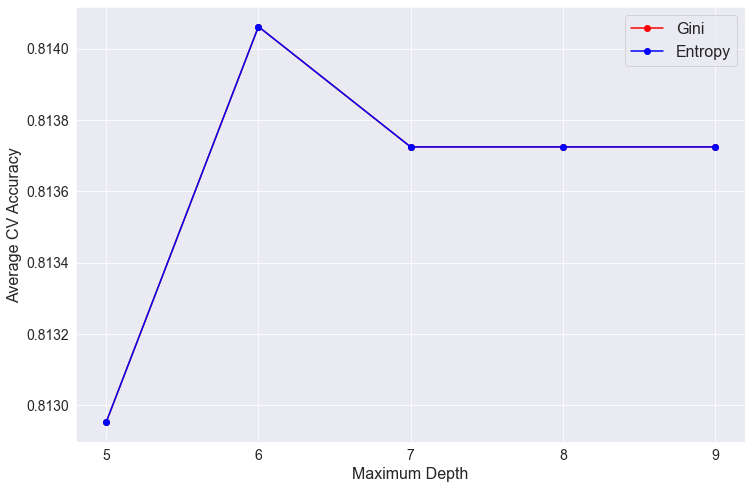

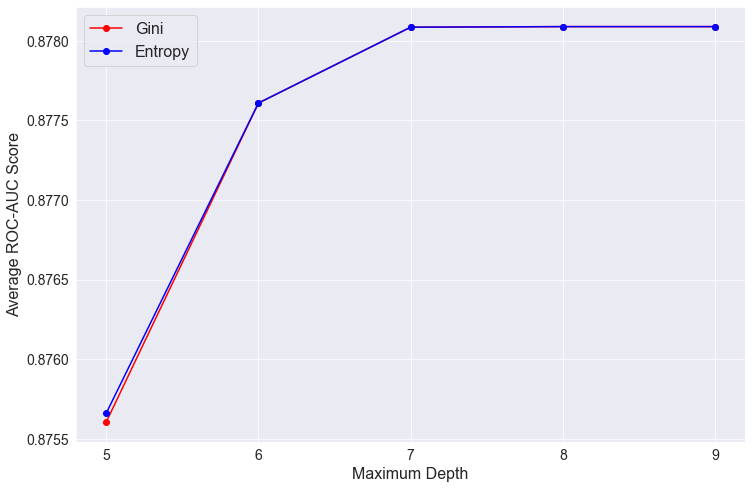

In [12]:
## this plots the average accuracy as a function of the maximum depth for both gini and entropy
plt.figure(figsize=(12,8))

#Plot average CV accuracy 
plt.plot(depth,np.mean(cv_accs_gini[:,1:], axis=0),
         '-o',color='red',
         label="Gini")

plt.plot(depth,np.mean(cv_accs_ent[:,1:], axis=0),
         '-o',color='blue',
         label="Entropy")

plt.legend(fontsize=16)

plt.xlabel("Maximum Depth", fontsize=16)
plt.ylabel("Average CV Accuracy", fontsize=16)

plt.xticks(depth, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## this plots the average ROC-AUC as a function of the maximum depth for gini and entropy
plt.figure(figsize=(12,8))
    
#Plot average CV accuracy 
plt.plot(depth,np.mean(cv_aucs_gini[:,1:], axis=0),
         '-o',color='red',
         label="Gini")
plt.plot(depth,np.mean(cv_aucs_ent[:,1:], axis=0),
         '-o',color='blue',
         label="Entropy")

plt.legend(fontsize=16)

plt.xlabel("Maximum Depth", fontsize=16)
plt.ylabel("Average ROC-AUC Score", fontsize=16)

plt.xticks(depth, fontsize=14)
plt.yticks(fontsize=14)

plt.show()

We see gini and entropy perform about equally on accuracy and ROC-AUC, so our chosen decision tree model will be with gini, and depth 8 to maximize ROC-AUC. Here, we run this on our full train set, and save the first 4 levels of this decision tree as a png.

In [13]:
print("The best decision tree from our cross validation is gini with max_depth=8.")
print("It's average ROC-AUC on the validation subsets is:",np.mean(cv_aucs_gini,axis=0)[np.argmax(np.mean(cv_aucs_gini,axis=0))])
print("It's average accuracy on the validation subsets is:",np.mean(cv_accs_gini,axis=0)[np.argmax(np.mean(cv_accs_gini,axis=0))])

The best decision tree from our cross validation is gini with max_depth=8.
It's average ROC-AUC on the validation subsets is: 0.8780896819577363
It's average accuracy on the validation subsets is: 0.8140615163234104


In [14]:
dtree=DecisionTreeClassifier(max_depth=8,random_state=10475)
fig=dtree.fit(X_train, y_train)

In [ ]:
plt.figure(figsize = (100,100))

## Plot the fitted tree
tree.plot_tree(fig,label='all', filled = True,max_depth=4,feature_names=X_train.columns,proportion=True)
plt.savefig("pa_form_dec_tree.png")

We see that going 3 levels deep in the tree, reject code, drug C, contraindication, tried and failed, and bin 417740 are used for splits. These are also identified in Lasso feature selection in the Logistic Regression notebook as most important.

Finally, we look at the ROC-AUC score and accuaracy score on the whole train set.

In [ ]:
pred=dtree.predict(X_train)
predp=dtree.predict_proba(X_train)

print("For the chosen decision tree model, the accuracy on the training set is",accuracy_score(y_train,pred))
print("For the chosen decision tree model, the ROC-AUC on the training set is",roc_auc_score(y_train,predp))